In [88]:
import pandas as pd
import numpy as np

import tensorly as tl
from tqdm import tqdm
import imageio

import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter
from numpy.linalg import inv as inv
from numpy.linalg import pinv as pinv

In [89]:
def xind2mul(vec, child):
    newvec = np.zeros(len(vec))
    d = np.int(child ** 0.5)
    xind = np.zeros((d, d)).astype(int)
    for i in range(d):
        xind[:, i] = i
    xind = xind.reshape([child])
    for i in range(len(vec)):
        newvec[i] = xind[vec[i]]
    return newvec

def yind2mul(vec, child):
    newvec = np.zeros(len(vec))
    d = np.int(child ** 0.5)
    xind = np.zeros((d, d)).astype(int)
    for i in range(d):
        xind[i, :] = i
    xind = xind.reshape([child])
    for i in range(len(vec)):
        newvec[i] = xind[vec[i]]
    return newvec

def invKA(tensor, tind):
    child = tensor.shape[0]
    dim1, dim2, dimn = tind.shape
    d = np.int(child ** 0.5)
    weightd = np.ones(dimn)
    for i in range(dimn):
        weightd[i] = d ** (dimn - 1 - i)

    image = np.zeros((dim1, dim2, 3)).astype(int)
    for i in range(dim1):
        for j in range(dim2):
            newind = tind[i, j, :]
            x = np.int(np.matmul(xind2mul(newind, child), weightd))
            y = np.int(np.matmul(yind2mul(newind, child), weightd))
            indtuple = tuple(map(tuple, newind.reshape(len(newind),1)))
            image[x, y, :] = tensor[indtuple]
    return image
def KA(image, child):
    dim1, dim2, dim3 = image.shape
    dimn = np.int(np.log(dim1) / np.log(child) + np.log(dim2) / np.log(child))
    newdim = []
    for i in range(dimn):
        newdim.append(child)
    newdim.append(dim3)
    highordertensor = np.zeros(newdim)
    d = np.int(child ** 0.5)
    indmat = np.arange(0, child, 1).reshape([d, d], order = 'F').astype(int)
    newind = np.zeros((dim1, dim2, dimn)).astype(int)
    for i in range(dim1):
        for j in range(dim2):
            x = i
            y = j
            for k in range(dimn):
                indx = np.int(x % d)
                indy = np.int(y % d)
                newind[i, j, dimn - k - 1] = indmat[indx, indy]
                x = x // d
                y = y // d 
            indtuple = tuple(map(tuple, newind[i, j, :].reshape(len(newind[0,0,:]),1)))
            highordertensor[indtuple] = image[i, j, :]
    return highordertensor, newind

# highordertensor, tind = KA(T, 4)
# print(highordertensor.ndim)
# print(T.shape)
# print(highordertensor.shape)
# print(tind.shape)
# image_rec = invKA(highordertensor, tind)
# print(image_rec.shape)
# print(type(image_rec))
# plt.imshow(image_rec)

def SVD_MPS_Rank_Estimation(X,th):
    #Function to decompose a high-order rank tensor into an MPS
    N =  X.ndim
    RankX = np.zeros(N-1)
    sizX = X.shape
    T = X.reshape([sizX[0], np.prod(sizX[1:])]).copy()
    for k in range(N - 1):
#         print(T.shape)
        _ , S, V, chi = svd_RankEstimate(T,th) 
        T = np.matmul(S, V)
        intersz = np.append(np.array([chi]), sizX[k + 1: ])
        T = T.reshape(intersz).copy()
        if k < N-2:
            T = T.reshape([chi * sizX[k+1], np.prod(sizX[(k+2):])]).copy()        
        RankX[k] = chi
    return RankX

def svd_RankEstimate(T,th):
    U, S, V=np.linalg.svd(T, full_matrices = 0)
#     V=V.T
    chi = 0
    szS = len(S) 
    for k in range(szS):
        if S[k]/S[0] > th:
            chi = chi+1
    chi = max(chi,2)
    U = U[:,0:chi]
    S = np.diag(S[0:chi])
    V = V[0:chi,:]
#    print('The original rank is %d and truncated rank is %d'%(szS,chi))
    return U, S, V, chi

def Tmac_TT(dense_tensor, sparse_tensor, maxiter, th):
    """Main function of the Tmac-TT for 9th-order tensor."""
    
    dim = [4, 4, 4, 4, 4, 4, 4, 4, 3]
    weight = weightTC(dim)
    sparse_tensor_new, tind = KA(sparse_tensor, child = 4)
    dim0 = sparse_tensor_new.ndim
    tensor_hat_new = sparse_tensor_new.copy()
    binary_tensor = sparse_tensor_new.copy()
    binary_tensor[np.where(sparse_tensor_new != 0)] = 1
    X = np.random.rand(4, 4, 4, 4, 4, 4, 4, 4, 3, dim0 - 1)
    for k in range(dim0 - 1):
        X[:, :, :, :, :, :, :, :, :, k] = tensor_hat_new
    
    U_list = []
    V_list = []
    rank = SVD_MPS_Rank_Estimation(sparse_tensor_new, th)
    rank = rank.astype(int)
    for k in range(dim0 - 1):
        U_list.append(0.1 * np.random.rand(4 ** (k + 1), rank[k]))
        V_list.append(0.1 * np.random.rand(rank[k], 4 ** (8 - k - 1) * 3))
    for iters in range(maxiter):
        for k in range(dim0 - 1):
            unfold_var = X[:, :, :, :, :, :, :, :, :, k].reshape([4 ** (k + 1), 4 ** (8 - k - 1) * 3], order = 'F')
            U_list[k] = np.matmul(unfold_var, V_list[k].T)
            var = pinv(np.matmul(U_list[k].T, U_list[k]))
            V_list[k] = np.matmul(np.matmul(var, U_list[k].T), unfold_var)
            X[:, :, :, :, :, :, :, :, :, k] = np.matmul(U_list[k], V_list[k]).reshape(dim, order = 'F')
        tensor_hat_new = np.multiply(1 - binary_tensor, np.dot(X, weight)) + sparse_tensor_new
        for k in range(dim0 - 1):
            X[:, :, :, :, :, :, :, :, :, k] = tensor_hat_new.copy()
    tensor_hat = invKA(tensor_hat_new, tind)
    return tensor_hat


def weightTC(dim):
    N = len(dim)
    weight = np.zeros(N-1)
    IL = dim[0]
    for k in range(N - 1):
        IR = np.prod(dim[k+1:])
        weight[k] = min(IL,IR)
        IL = IL * dim[k+1]
    weight = weight/(sum(weight))
    return weight



/tmp/ipykernel_95969/414004207.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  T = imageio.imread('house.bmp')#[100:-50,100:-50]


Array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

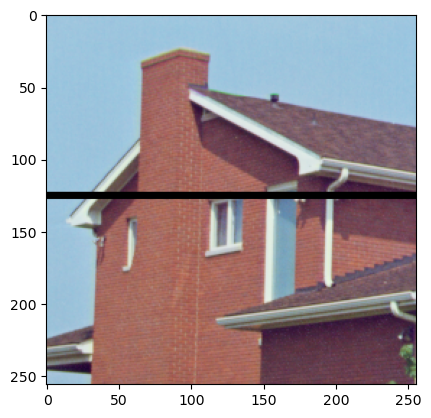

In [84]:
tl.set_backend('pytorch')




T = imageio.imread('house.bmp')#[100:-50,100:-50]
# T = T/255
# T = np.concatenate([T,T,T,T],axis=-1)
np.random.seed(4)
# T = tl.tensor(np.random.normal(0,1,[40,40,3]))
n,m,i = T.shape
# i = np.random.randint(0,n,10)
# i[0] = 1
# j = np.random.randint(0,m,10)
# j[0] = 2
# i = [23,24,25,26,27,78,79,80,56,34,152,153,154,123,124,125,126,127,178,179,180,156]
i = [123,124,125,126,127]

# for a in range(150,160):
#     i.append(a)
# j = [23,24,25,26,27,78,79,80,56,34]
mask = np.ones((n,m)).astype(bool)
mask[i,:] = False
# mask[:,j] = False
TM = T.copy()
TM[~mask] = [0,0,0]
fig,ax = plt.subplots()

plt.imshow(T)
plt.imshow(TM)
TM[~mask]



/tmp/ipykernel_95969/1567346652.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dimn = np.int(np.log(dim1) / np.log(child) + np.log(dim2) / np.log(child))
/tmp/ipykernel_95969/1567346652.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additio

23.416791304141


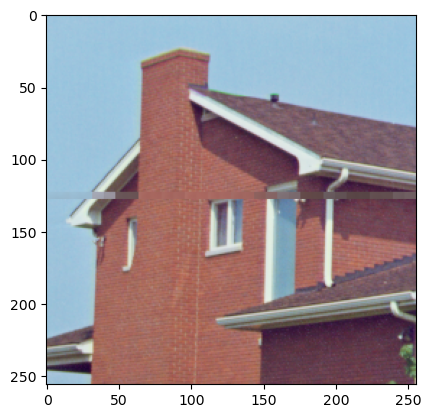

In [92]:
maxiter = 200
th = 0.2
image = T
sparse_image = TM
image_hat = Tmac_TT(image, sparse_image, maxiter, th)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)

print(100 * rse)

fig,ax = plt.subplots()

plt.imshow(image_rec)
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)


In [101]:
# fig,ax = plt.subplots()

# # plt.imshow(T)
# plt.imshow(T_new.astype(int))
T.shape

def tr_to_tensor(a):
    A,B,C = a
    return tl.einsum('nai,ibj,jcn-> abc',A,B,C)
T.max()

246

## (Geng et al., 2011) 


In [123]:
#Create random tensor, will be replaced by Spectrogram afterwards
# mask = ~mask
TM = T.astype(np.float64)
TM[~mask] = np.nan #Tensor with missing values

Xm = np.nanmean(TM,axis=1)
Ym = np.nanmean(TM,axis=0)
Xm[np.isnan(Xm)] = 0
Ym[np.isnan(Ym)] = 0
Mm = Xm[:,np.newaxis]+Ym[np.newaxis]
Mm[Mm[:,:,0]==0,:] = np.nanmean(Mm,axis=(0,1))
Mm = uniform_filter(Mm, size=[10,10,0], mode='constant')
# TM = T.detach().clone()
# tensorly.decomposition.
# (np.nanmean(TM,axis=0)[:,np.newaxis]+np.nanmean(TM,axis=1)[np.newaxis])


#not needed but to be sure
T_new = TM
T_new[~mask] = Mm[~mask]

T_new = tl.tensor(T_new, device='cuda', dtype=tl.float64)
TM = tl.tensor(TM, device='cuda', dtype=tl.float64)

max_it = 100
norm = 1
epsilon = 1e-10
r = 10
i = 0
bar = tqdm()
nl = list()
nd = list()
while (i<max_it) : #& (norm > epsilon)
    
    T_old = T_new.clone().detach()
    T_old[mask] = TM[mask].clone().detach()

    T_new = tl.tucker_to_tensor(tl.decomposition.tucker(tensor=T_old,rank=[150,150,2],n_iter_max=100,svd = 'randomized_svd',init='random'))
    T_new[T_new >255] = 255
    T_new[T_new < 0] = 0
    # T_new = tl.tt_to_tensor(tl.decomposition.tensor_train(input_tensor=T_old.clone().detach(),rank=[1,10,2,1],svd = 'randomized_svd'))
    # T_new = tr_to_tensor(tl.decomposition.tensor_ring(input_tensor=T_old.clone().detach(),rank=[2,4,2,2],svd = 'randomized_svd'))

    norm = tl.norm(TM[mask] - T_new[mask])/tl.norm(TM[mask])
    i += 1
    rse = 100*np.linalg.norm(T_old[~mask].cpu().numpy() - T[~mask], 2) / np.linalg.norm(T[~mask], 2)

    bar.update(1)
    bar.set_description("norm : " + str(norm) + "Diff :" + str(rse))
    nl.append(norm.cpu().numpy())
    nd.append(rse)
norm,max_it

/tmp/ipykernel_95969/845815208.py:6: RuntimeWarning: Mean of empty slice
  Xm = np.nanmean(TM,axis=1)
norm : tensor(0.0595, device='cuda:0', dtype=torch.float64)Diff :71.40796334276722: : 100it [01:04,  1.55it/s]
norm : tensor(0.0507, device='cuda:0', dtype=torch.float64)Diff :71.70548912478856: : 100it [01:12,  1.35it/s]

(tensor(0.0507, device='cuda:0', dtype=torch.float64), 100)

71.40796334276722

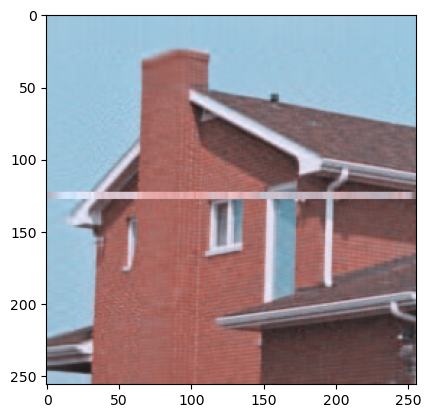

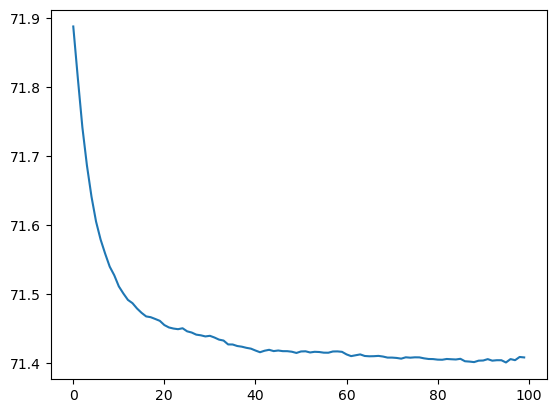

In [122]:

fig,ax = plt.subplots()

# # plt.imshow(T)$

plt.imshow(T_new.cpu().numpy().astype(int))
fig,ax = plt.subplots()
# ax.plot(nl[1:]-nl[0])
ax.plot(nd)
nd[-1]


tensor(25.2649, device='cuda:0', dtype=torch.float64)

In [26]:
np.random.seed(4)
T = tl.tensor(np.random.normal(0,1,[40,40,3]))
n,m,i = T.shape
i = np.random.randint(0,n,50)
i[0] = 1
j = np.random.randint(0,m,50)
j[0] = 2
mask = np.ones((n,m)).astype(bool)
mask[i,:] = False
mask[:,j] = False

TM = T.copy()
TM[~mask] = np.nan #Tensor with missing values
# tensorly.decomposition.
# (np.nanmean(TM,axis=0)[:,np.newaxis]+np.nanmean(TM,axis=1)[np.newaxis])
Xm = np.nanmean(TM,axis=1)
Ym = np.nanmean(TM,axis=0)

Xm[np.isnan(Xm)] = 0
Ym[np.isnan(Ym)] = 0
Mm = Xm[:,np.newaxis]+Ym[np.newaxis]
Mm[Mm[:,:,0]==0,:] = np.nanmean(Mm,axis=(0,1))

#not needed but to be sure

T_new = TM.copy()
T_new[~mask] = Mm[~mask]

max_it = 1000
norm = 1
epsilon = 1e-10
r = 10
i = 0
while (i<max_it) & (norm > epsilon):
    
    T_old = T_new
    T_old[mask] = TM[mask]

    T_new = tl.tucker_to_tensor(tl.decomposition.tucker(tensor=T_old,rank=r,n_iter_max=100))
    norm = tl.norm(T_old[mask] - T_new[mask])/tl.norm(T_old[mask])
    i += 1

norm,max_it

/tmp/ipykernel_9584/3215433506.py:16: RuntimeWarning: Mean of empty slice
  Xm = np.nanmean(TM,axis=1)
/tmp/ipykernel_9584/3215433506.py:17: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(TM,axis=0)


KeyboardInterrupt: 

In [10]:
def khatri_rao(A,B):
    assert A.shape[1] == B.shape[1], "A and B must have the same number of columns"
    return np.einsum('ir,jr->ijr',A,B).reshape(A.shape[0]*B.shape[0],A.shape[1])

def CP_ALS(T, rank, epsilon=1e-5,max_iters=100,verbose=True,errors_at_iterations=[]):
    # Initialize A, B and C
    # YOUR CODE HERE
    
    A,B,C = [np.random.normal(0,1, [d,rank]) for d in T.shape]


    T_approx_old = tl.kruskal_to_tensor((np.ones(rank),[A,B,C]))
    it = 1
    while True: # repeat until convergence
        # update the factor matrices A, B and C. Here are a couple of indications:
        # - to efficiently solve a least square problem you can use numpy.lstsq
        # - matricizations (unfolding) of T can be obtained using tl.unfold
        # - to compute the Khatri-Rao product use the function khatri_rao defined above
        # YOUR CODE HERE

        A = np.linalg.lstsq(a=khatri_rao(B,C),b=tl.unfold(T,mode=0).T,rcond=None)[0].T
        B = np.linalg.lstsq(a=khatri_rao(A,C),b=tl.unfold(T,mode=1).T,rcond=None)[0].T
        C = np.linalg.lstsq(a=khatri_rao(A,B),b=tl.unfold(T,mode=2).T,rcond=None)[0].T
        # check for convergence:
        T_approx_new = tl.kruskal_to_tensor((np.ones(rank),[A,B,C]))
        reconstruction_error =  tl.norm(T_approx_new-T)
        errors_at_iterations.append(reconstruction_error)  
      
        if tl.norm(T_approx_old - T_approx_new)/tl.norm(T_approx_old) < epsilon or it > max_iters:
            return (A,B,C)
        if verbose:
            print(it, " - reconstruction error: ",reconstruction_error, "convergence: ", tl.norm(T_approx_old - T_approx_new)/tl.norm(T_approx_old))

        
        T_approx_old = T_approx_new
        it += 1

rank = 2
A,B,C = [np.random.normal(0,1, [d,rank]) for d in T.shape]



SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Successfully Exit')? (helios.py, line 30)